# Solve time dependent Schroedinger equation in 1D, using FFT method
Harmonic oscillator coherent state

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.integrate import simps

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

The general solution follows the method of http://jakevdp.github.com/blog/2012/09/05/quantum-python/

* Use the potential to propagate a half time step in x space
* FFT
* Use the kinetic energy operator to propagate one whole time step in k space
* IFFT
* Use the potential to propagate a half time step in x space

For time varying potentials, the propagation term is exp(-i integral(V(x),dt)/hbar).  The integral can be done analytically or numerically.  Here, if numerical integration is used, we use one step of the trapezoidal approximation.  This may not work if the time step is too large.

Hard boundaries are assumed.  Be sure xmin and xmax are sufficiently far from the region of interest for the initial state you choose.

In [21]:
#constants (change these to fit the problem)
hbar = 1.0
m = 1.0 #mass
tmin = 0.0 # initial time
tmax = 10.0 # final time
Nt = 2000 # number of time steps
xmin = -2.0 # minimum x value
xmax = 2.0 # maximum x value
Nx = 4096 # number of steps in x (and k).  Must be even, power of 2 is better

In [22]:
#calculate lists
xlist = np.linspace(xmin,xmax,Nx)
tlist = np.linspace(tmin,tmax,Nt)
dx = xlist[1]-xlist[0] # delta x
dt = tlist[1]-tlist[0] # delta t
dk = 2 * np.pi/np.abs(xmax-xmin) # delta k (from FFT definition)
kmax = 0.5*Nx*dk # (Nyquist limit)
klist = np.roll(np.arange(-Nx//2+1,Nx//2+1),Nx//2+1)*dk #list of k values, indexed according to FFT convention, double // means integer part of quotient

The potential below is a harmonic oscillator potential.  Try using other potentials.

In [23]:
#define potential function (needs to be vectorizable)
def V(x,t):
    # infinite square well
    halfwidth = 1.0
    height = 1e30 # some large number
    return height*np.heaviside(np.abs(x)-halfwidth,0)

In [24]:
# integral of V dt, evaluated at x
def intV(x,ti,tf):
    #indef = lambda x,t: 0.5*x**2*t# indefinite integral
    #out = indef(x,tf)-indef(x,ti)
    out = 0.5*(V(x,ti)+V(x,tf))*(tf-ti) #trapezoidal rule (backup plan)
    return out

In [25]:
#initial wavefunction at t=tmin (normalization optional)
def psi0(x):
    halfwidth = 1.0
    return (x**2-halfwidth**2)*np.heaviside(halfwidth-np.abs(x),0)

In [26]:
psilist = np.zeros([Nx,Nt],dtype=np.cfloat) # initialize array to store wavefunction

In [27]:
psilist[:,0]=psi0(xlist) # store initial wavefunction

In [28]:
#main loop
for tindex in np.arange(1,Nt):
    psix = psilist[:,tindex-1]*np.exp(-1.j*intV(xlist,tlist[tindex-1],tlist[tindex]+0.5*dt)/hbar)
    psix[0:3] = 0; psix[-4:-1] = 0; # enforce boundary conditions
    psik = fft(psix)
    psik = psik * np.exp(-0.5j*hbar*klist*klist*dt/m)
    psix = ifft(psik)
    psix = psix*np.exp(-1.j*intV(xlist,tlist[tindex]-0.5*dt,tlist[tindex])/hbar)
    psix[0:3] = 0; psix[-4:-1] = 0; # enforce boundary conditions
    psilist[:,tindex] = psix

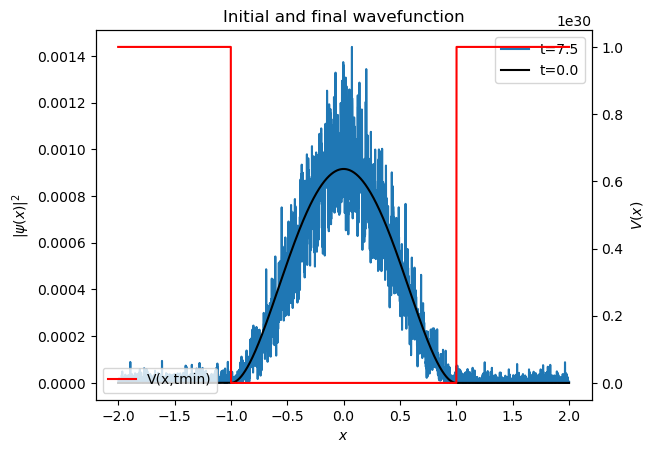

In [41]:
tdraw = 1500 # time index for plot (-1 is last time value)
Nf = simps(np.abs(psilist[:,tdraw])**2) # normalization of final state
Ni = simps(np.abs(psilist[:,0])**2) # normalization of initial state
fig, ax1 = plt.subplots()
ax1.plot(xlist,np.abs(psilist[:,tdraw])**2/Nf,label='t={0:.1f}'.format(tlist[tdraw]))
ax1.plot(xlist,np.abs(psilist[:,0])**2/Ni,'k',label='t={0:.1f}'.format(tmin))
ax2 = ax1.twinx()
ax2.plot(xlist,V(xlist,tmin),'r',label='V(x,tmin)')
ax1.set_ylabel('$|\psi(x)|^2$')
ax2.set_ylabel('$V(x)$')
ax1.set_xlabel('$x$')
ax1.legend()
ax1.set_title("Initial and final wavefunction")
ax2.legend()

In [42]:
# Calculate expectation values of x, p, x2, p2
EVxlist = np.zeros(Nt)
EVplist = np.zeros(Nt)
EVx2list = np.zeros(Nt)
EVp2list = np.zeros(Nt)
Nlistx = np.zeros(Nt)
Nlistp = np.zeros(Nt)
Elist = np.zeros(Nt)
for t in range(Nt):
    Nlistx[t] = simps(np.abs(psilist[:,t])**2) # Normalization denominator
    EVxlist[t] = simps(xlist*np.abs(psilist[:,t])**2)/Nlistx[t] # x
    EVx2list[t] = simps(xlist**2*np.abs(psilist[:,t])**2)/Nlistx[t]-EVxlist[t]**2 # Var(x)
    psik = fft(psilist[:,t]) 
    Nlistp[t] = simps(np.abs(psik)**2) # Normalization denominator
    EVplist[t] = hbar*simps(klist*np.abs(psik)**2)/Nlistp[t] # p 
    EVp2list[t] = (simps((hbar*klist)**2*np.abs(psik)**2)/Nlistp[t]-EVplist[t]**2) # Var(p)
    Elist[t] = 0.25/m*simps((hbar*klist)**2*np.abs(psik)**2)/Nlistp[t]+simps(V(xlist,t)*np.abs(psilist[:,t]**2))/Nlistx[t] # Energy

Text(0.5, 1.0, 'Center of mass and width')

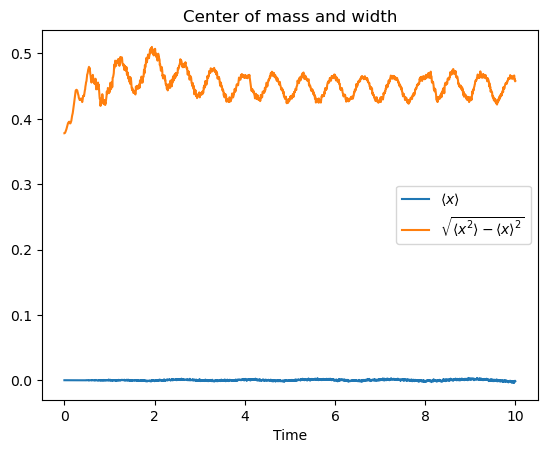

In [43]:
plt.plot(tlist,EVxlist,label=r'$\langle x \rangle$')
plt.plot(tlist,np.sqrt(EVx2list),label=r'$\sqrt{\langle x^2 \rangle-\langle x \rangle ^2}$')
plt.legend()
plt.xlabel('Time')
plt.title('Center of mass and width')

Text(0.5, 1.0, 'Average momentum and momentum width')

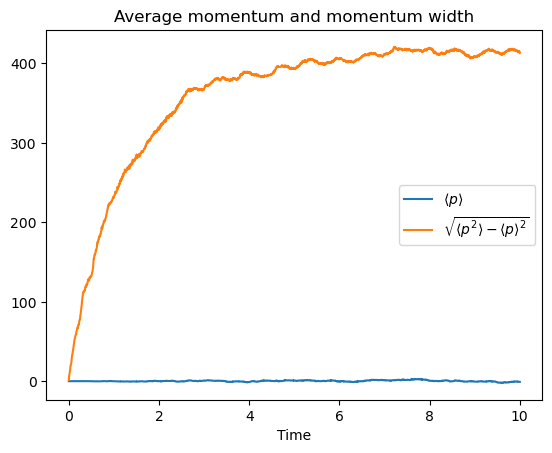

In [44]:
plt.plot(tlist,EVplist,label=r'$\langle p \rangle$')
plt.plot(tlist,np.sqrt(EVp2list),label=r'$\sqrt{\langle p^2 \rangle-\langle p \rangle ^2}$')
plt.legend()
plt.xlabel('Time')
plt.title("Average momentum and momentum width")

Text(0.5, 1.0, 'Energy')

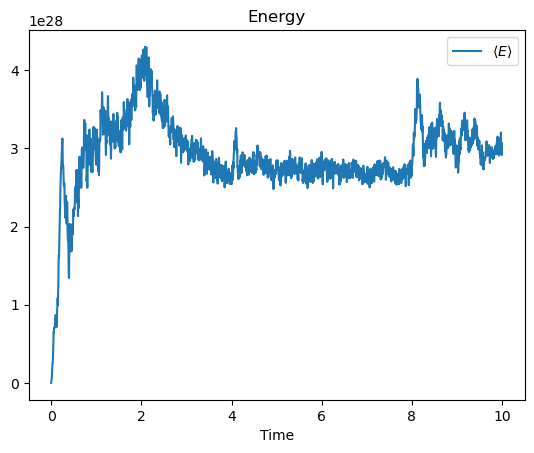

In [45]:
plt.plot(tlist,Elist,label=r'$\langle E \rangle$')
#plt.plot(tlist,np.sqrt(EVx2list),label=r'$\sqrt{\langle x^2 \rangle-\langle x \rangle ^2}$')
plt.legend()
plt.xlabel('Time')
plt.title('Energy')

Yikes, energy is not conserved.  Need to figure out where the integrator goes bad.